In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2019-07-09 20:24:45--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2019-07-09 20:24:45 (127 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [3]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


W0709 20:24:48.228797 139657366222720 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0709 20:24:48.255798 139657366222720 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0709 20:24:48.262032 139657366222720 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [4]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

W0709 20:24:49.271410 139657366222720 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
15462/15462 [==============================] - 29s 2ms/sample - loss: 6.9078 - acc: 0.0216
Epoch 2/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.5012 - acc: 0.0230
Epoch 3/100
15462/15462 [==============================] - 26s 2ms/sample - loss: 6.3849 - acc: 0.0265
Epoch 4/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.2602 - acc: 0.0300
Epoch 5/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.1651 - acc: 0.0373
Epoch 6/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.0832 - acc: 0.0385
Epoch 7/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.0027 - acc: 0.0407
Epoch 8/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 5.9163 - acc: 0.0448
Epoch 9/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 5.8088 - acc: 0.0521
Epoch 10/100
15462/15462 [==============================] - 25s 2ms/sampl

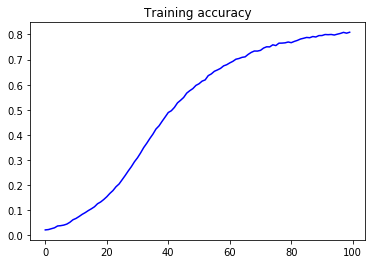

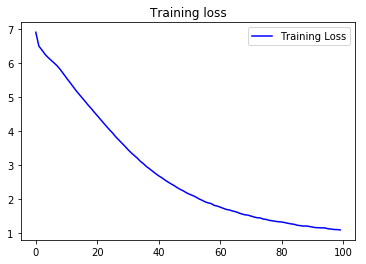

In [5]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [6]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope doth hell and green you taken halt shown appear ye ' removed of summer's doom and cold torn torn torn torn torn ' did latch halt still up hate new hate new new delight delight delight delight delight wrong delight wrong delight delight quite known stand ruining quite burn out walls of steel woe ye date cold quite shaken forgot mother taken taken twain ' knows now them so bad so told me so thee you dumb 'tis earth is stay so dumb dead minds me alone acquainted acquainted ' lack well mother sinful do clear deeds of be belied
